In [1]:
!pip install pycuda

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 1.7 MB 5.4 MB/s 
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
    Preparing wheel metadata ... done
     |████████████████████████████████| 69 kB 9.4 MB/s 
     |████████████████████████████████| 78 kB 8.0 MB/s 
  Created wheel for pycuda: filename=pycuda-2021.1-cp37-cp37m-linux_x86_64.whl size=626634 sha256=e4f4e3c54f499ae25319d82cdaa875d93726203fd516d6d67706ea920f9434fe
  Stored in directory: /root/.cache/pip/wheels/c4/ef/49/dc6a5feb8d980b37c83d465ecab24949a6aa19458522a9e001
  Created wheel for pytools: filename=pytools-2022.1.9-py2.py3-none-any.whl size=64666 sha256=fbb18870b3861224c8fc17f13162ca240a231d792c5b706e2d52c3960e5abba3
  Stored in directory: /root/.cache/pip/wheels/11/d8/85/01a8cf50977badf2da880865124b159b112b861655a9b631d3
Successfully built pycuda pytools


In [2]:
import pycuda.autoinit
import pycuda.driver as drv
from pycuda import gpuarray
from pycuda.compiler import SourceModule
import numpy as np
import matplotlib.pyplot as plt
from time import time

# Basic tool

In [3]:
calculate_ker = SourceModule(
    """
    #define _X (threadIdx.x + blockIdx.x * blockDim.x * blockDim.y)

    #define _WIDTH (blockDim.x)

    #define _INDEX1(x,y) (x * _WIDTH + y)

    // A: matrix, b: vector, out: vector
    __global__ void mat_vec_ker(float *out, float *A, float *b, float *theta)
    {
        int x = _X;

        for (int j = 0; j < _WIDTH; j++)
        {
            // out need to be initialized
            out[x] += A[_INDEX1(x,j)] * theta[j];
        }

        __syncthreads();
        out[x] -= b[x];
        __syncthreads();
    }
    """
)

gradient_ker = SourceModule(
    """
    #define _X (threadIdx.x)

    #define _WIDTH (blockDim.x)

    __global__ void gradient_ker(float *grad, float *out, float *A, int width)
    {
        int x = _X;
        int w = _WIDTH * width;

        for (int k = 0; k < w; k++)
        {
            int index = k * _WIDTH + x;
            grad[x] += A[index] * out[k];
        }

        __syncthreads();
    }
    """
)

update_ker = SourceModule(
    """
    #define _X (threadIdx.x + blockIdx.x * blockDim.x * blockDim.y)

    __global__ void update_ker(float *theta_new, float *theta, float lr, float *grad)
    {
        int x = _X;

        theta_new[x] = theta[x] - grad[x] * lr;

        __syncthreads();
    }
    """
)

multiply = calculate_ker.get_function("mat_vec_ker")
gradient = gradient_ker.get_function("gradient_ker")
update = update_ker.get_function("update_ker")

In [4]:
# set matrix size
# BD: blockDim, GD: gridDim   
BD = 32 * 32
GD_x = 2

lr = np.float32(1e-6)

A = np.float32(np.random.randn(BD*GD_x,BD))
b = np.float32(np.random.randn(BD*GD_x))
theta = np.float32(np.random.randn(BD))
out_cpu = np.float32(np.zeros((BD,GD_x+1)))

A_gpu = gpuarray.to_gpu(A.reshape(BD*BD*GD_x))
b_gpu = gpuarray.to_gpu(b)
theta_gpu = gpuarray.to_gpu(theta)
theta_new_gpu = gpuarray.to_gpu(theta)
out_gpu = gpuarray.empty_like(b_gpu)
grad_gpu = gpuarray.empty_like(theta_gpu)
init_gpu1 = gpuarray.empty_like(theta_gpu)
init_gpu2 = gpuarray.empty_like(b_gpu)

# initialize
out_gpu[:] = init_gpu2
grad_gpu[:] = init_gpu1
theta_gpu[:] = theta_new_gpu[:]
theta_new_gpu[:] = init_gpu1

# in GPU
multiply(out_gpu, A_gpu, b_gpu, theta_gpu, block=(BD,1,1), grid=(GD_x,1,1))
gradient(grad_gpu, out_gpu, A_gpu, np.int32(GD_x), block=(BD,1,1), grid=(GD_x,1,1))
update(theta_new_gpu, theta_gpu, lr, grad_gpu, block=(BD,1,1), grid=(1,1,1))

# result_gpu = out_gpu.get()
# result_gpu = grad_gpu.get()
result_gpu = theta_new_gpu.get()

# in CPU
# result_cpu = np.dot(A, theta) - b
# result_cpu = np.dot(A.T, (np.dot(A,theta) - b))
result_cpu = theta - np.dot(A.T, (np.dot(A, theta) - b)) * lr

print(f"Does it right?: {np.allclose(result_cpu, result_gpu, atol=1e-4)}")
print(f"How about 2-Norm?: {np.linalg.norm(result_cpu - result_gpu)}")

Does it right?: True
How about 2-Norm?: 2.775603888949263e-07


# VS. lstsq

In [5]:
# set matrix size
# BD: blockDim, GD: gridDim   
BD = 32 * 32
GD_x = 16

lr = np.float32(1e-6)

A = np.float32(np.random.randn(BD*GD_x,BD))
b = np.float32(np.random.randn(BD*GD_x))
theta = np.float32(np.random.randn(BD))
out_cpu = np.float32(np.zeros((BD,GD_x+1)))

A_gpu = gpuarray.to_gpu(A.reshape(BD*BD*GD_x))
b_gpu = gpuarray.to_gpu(b)
theta_gpu = gpuarray.to_gpu(theta)
theta_new_gpu = gpuarray.to_gpu(theta)
out_gpu = gpuarray.empty_like(b_gpu)
grad_gpu = gpuarray.empty_like(theta_gpu)
init_gpu1 = gpuarray.empty_like(theta_gpu)
init_gpu2 = gpuarray.empty_like(b_gpu)

# in GPU
t1 = time()
for i in range(2):
    for i in range(200):
        # initialize
        out_gpu[:] = init_gpu2
        grad_gpu[:] = init_gpu1
        theta_gpu[:] = theta_new_gpu[:]
        theta_new_gpu[:] = init_gpu1

        # calculate
        multiply(out_gpu, A_gpu, b_gpu, theta_gpu, block=(BD,1,1), grid=(GD_x,1,1))
        gradient(grad_gpu, out_gpu, A_gpu, np.int32(GD_x), block=(BD,1,1), grid=(GD_x,1,1))
        update(theta_new_gpu, theta_gpu, lr, grad_gpu, block=(BD,1,1), grid=(1,1,1))
result_gpu = theta_new_gpu.get()
t2 = time()
run_GPU = t2 - t1
error_gpu = np.linalg.norm(np.dot(A,result_gpu) - b)

# in CPU
t1 = time()
result_cpu = np.linalg.lstsq(A,b, rcond=None)[0]
t2 = time()
run_CPU = t2 - t1
error_cpu = np.linalg.norm(np.dot(A,result_cpu) - b)

print(f"It took {run_GPU} seconds in GPU")
print(f"error in GPU: {error_gpu}")
print(f"It took {run_CPU} seconds in CPU")
print(f"error in CPU: {error_cpu}")

It took 2.709888219833374 seconds in GPU
error in GPU: 126.8155288696289
It took 2.8511931896209717 seconds in CPU
error in CPU: 124.79340362548828


In [6]:
class LeastSquare:
    def __init__(self, A, b, lr=1e-6, epoches=2, iterations=200, GD_x=16):
        # memorize data
        self.A = A
        self.b = b
        self.lr = np.float32(lr)
        self.epoches = epoches
        self.iterations = iterations
        
        # about data size
        self.BD = 32 * 32
        self.GD_x = GD_x

        # initialize data
        # data
        self.A_gpu = gpuarray.to_gpu(self.A.reshape(self.BD*self.BD*self.GD_x))
        self.b_gpu = gpuarray.to_gpu(self.b)
        # parameter
        theta = np.float32(np.random.randn(self.A.shape[1]))
        self.theta_gpu = gpuarray.to_gpu(theta)
        self.theta_new_gpu = gpuarray.to_gpu(theta)
        # what..?
        self.out_gpu = gpuarray.empty_like(self.b_gpu)
        self.init_gpu2 = gpuarray.empty_like(self.b_gpu)
        # gradient
        self.grad_gpu = gpuarray.empty_like(self.theta_gpu)
        self.init_gpu1 = gpuarray.empty_like(self.theta_gpu)

        # object
        self.opt_theta = None

    def optimize(self):
        for epoch in range(self.epoches):
            for iteration in range(self.iterations):
                # initialize
                self.out_gpu[:] = self.init_gpu2[:]
                self.grad_gpu[:] = self.init_gpu1[:]
                self.theta_gpu[:] = self.theta_new_gpu[:]
                self.theta_new_gpu[:] = self.init_gpu1[:]

                # calculate
                multiply(self.out_gpu, self.A_gpu, self.b_gpu, self.theta_gpu, block=(self.BD,1,1), grid=(self.GD_x,1,1))
                gradient(self.grad_gpu, self.out_gpu, self.A_gpu, np.int32(self.GD_x), block=(self.BD,1,1), grid=(self.GD_x,1,1))
                update(self.theta_new_gpu, self.theta_gpu, self.lr, self.grad_gpu, block=(BD,1,1), grid=(1,1,1))
        # ending
        self.opt_theta = theta_new_gpu.get()

        return self.opt_theta

    def lstsq(self):
        t1 = time()
        opt_theta = self.optimize()
        t2 = time()

        run_time = t2 - t1

        error = np.linalg.norm(np.dot(self.A, opt_theta) - self.b)

        return error, run_time

In [7]:
def stop_watch(n):
    BD = 32 * 32
    GD_x = n

    A = np.float32(np.random.randn(BD*GD_x,BD))
    b = np.float32(np.random.randn(BD*GD_x))

    LSTSQ = LeastSquare(A, b, GD_x=GD_x)

    # in GPU
    error_gpu, gpu_time = LSTSQ.lstsq()
    
    # in CPU
    t1 = time()
    result_cpu = np.linalg.lstsq(A,b, rcond=None)[0]
    t2 = time()

    error_cpu = np.linalg.norm(np.dot(A, result_cpu) - b)

    cpu_time = t2 - t1
    
    return error_gpu, error_cpu, gpu_time, cpu_time

In [10]:
N = 6

result = np.zeros((5,N))

for i in range(N):
    result[0,i] = 2**i * (32 * 32) ** 2
    result[1:,i] = stop_watch(2**i)

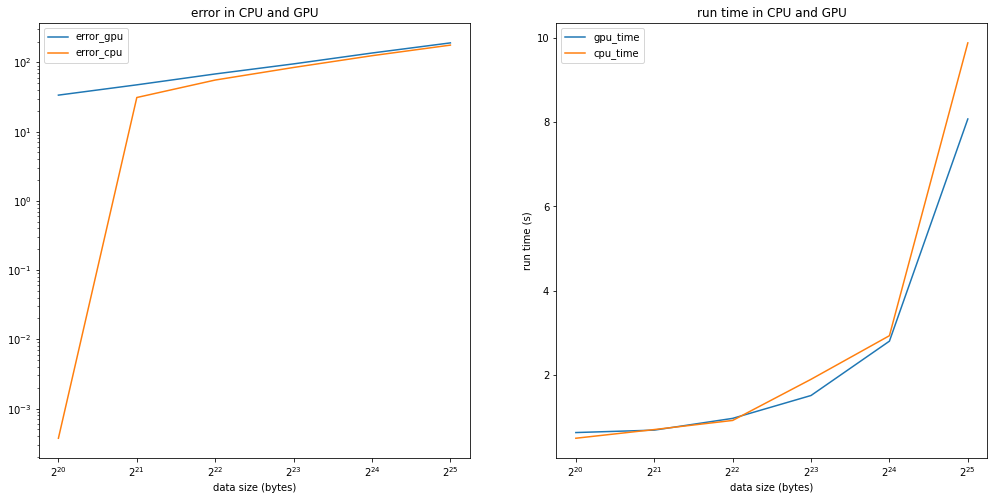

In [12]:
plt.figure(figsize=(17,8))

plt.subplot(121)
plt.plot(result[0,:], result[1,:], label="error_gpu")
plt.plot(result[0,:], result[2,:], label="error_cpu")
plt.loglog(basex=2)
plt.xlabel("data size (bytes)")
plt.title("error in CPU and GPU")
plt.legend()

plt.subplot(122)
plt.plot(result[0,:], result[3,:], label="gpu_time")
plt.plot(result[0,:], result[4,:], label="cpu_time")
plt.xscale("log", basex=2)
plt.xlabel("data size (bytes)")
plt.ylabel("run time (s)")
plt.title("run time in CPU and GPU")
plt.legend()

plt.show()

# DO faster!

In [15]:
import pycuda.autoinit

calculate_ker = SourceModule(
    """
    #define _X (threadIdx.x + blockIdx.x * blockDim.x * blockDim.y)

    #define _WIDTH (blockDim.x)

    #define _INDEX1(x,y) (x * _WIDTH + y)

    // A: matrix, b: vector, out: vector
    __global__ void mat_vec_ker(float *out, float *A, float *b, float *theta)
    {
        int x = _X;

        for (int j = 0; j < _WIDTH; j++)
        {
            // out need to be initialized
            out[x] += A[_INDEX1(x,j)] * theta[j];
        }

        __syncthreads();
        out[x] -= b[x];
        __syncthreads();
    }
    """
)

gradient_ker = SourceModule(
    """
    #define _X (threadIdx.x)
    #define _B (blockIdx.x)
    #define _G (gridDim.x)

    #define _WIDTH (blockDim.x)

    // grad_jerk: [BD,n], n = gridDim.x
    __global__ void gradient_ker(float *grad_jerk, float *out, float *A, int width)
    {
        int x = _X;
        int index_g = x * _G + _B;
        int index_a;
        int index_o;

        for (int k = 0; k < _WIDTH; k++)
        {
            index_a = x + k * _WIDTH + _B * _WIDTH * _WIDTH;
            index_o = k + _B * _WIDTH;

            grad_jerk[index_g] += A[index_a] * out[index_o];
        }

        __syncthreads();
    }

    __global__ void finish_ker(float *grad, float *grad_jerk)
    {
        int x = _X;

        for (int k = 0; k < _G; k++)
        {
            int index = x * _G + k;
            grad[x] += grad_jerk[index];
        }
        __syncthreads();
    }
    """
)

update_ker = SourceModule(
    """
    #define _X (threadIdx.x + blockIdx.x * blockDim.x * blockDim.y)

    __global__ void update_ker(float *theta_new, float *theta, float lr, float *grad)
    {
        int x = _X;

        theta_new[x] = theta[x] - grad[x] * lr;

        __syncthreads();
    }
    """
)

multiply = calculate_ker.get_function("mat_vec_ker")
gradient = gradient_ker.get_function("gradient_ker")
finish = gradient_ker.get_function("finish_ker")
update = update_ker.get_function("update_ker")

In [16]:
# set matrix size
# BD: blockDim, GD: gridDim   
BD = 32 * 32
GD_x = 2

lr = np.float32(1e-6)

A = np.float32(np.random.randn(BD*GD_x,BD))
b = np.float32(np.random.randn(BD*GD_x))
theta = np.float32(np.random.randn(BD))
grad_jerk = np.float32(np.zeros((BD,GD_x)))

A_gpu = gpuarray.to_gpu(A.reshape(BD*BD*GD_x))
b_gpu = gpuarray.to_gpu(b)
theta_gpu = gpuarray.to_gpu(theta)
theta_new_gpu = gpuarray.to_gpu(theta)
out_gpu = gpuarray.empty_like(b_gpu)
grad_jerk_gpu = gpuarray.to_gpu(grad_jerk.reshape(BD*GD_x))
grad_gpu = gpuarray.empty_like(theta_gpu)
init_gpu1 = gpuarray.empty_like(theta_gpu)
init_gpu2 = gpuarray.empty_like(b_gpu)
init_gpu3 = gpuarray.empty_like(grad_jerk_gpu)

# initialize
grad_jerk_gpu[:] = init_gpu3
out_gpu[:] = init_gpu2
grad_gpu[:] = init_gpu1
theta_gpu[:] = theta_new_gpu[:]
theta_new_gpu[:] = init_gpu1

# in GPU
multiply(out_gpu, A_gpu, b_gpu, theta_gpu, block=(BD,1,1), grid=(GD_x,1,1))
gradient(grad_jerk_gpu, out_gpu, A_gpu, np.int32(GD_x), block=(BD,1,1), grid=(GD_x,1,1))
finish(grad_gpu, grad_jerk_gpu, block=(BD,1,1), grid=(GD_x,1,1))
update(theta_new_gpu, theta_gpu, lr, grad_gpu, block=(BD,1,1), grid=(1,1,1))

# result_gpu = out_gpu.get()
# result_gpu = grad_gpu.get()
result_gpu = theta_new_gpu.get()

# in CPU
# result_cpu = np.dot(A, theta) - b
# result_cpu = np.dot(A.T, (np.dot(A,theta) - b))
result_cpu = theta - np.dot(A.T, (np.dot(A, theta) - b)) * lr

print(f"Does it right?: {np.allclose(result_cpu, result_gpu)}")
print(f"How about 2-Norm?: {np.linalg.norm(result_cpu - result_gpu)}")

Does it right?: False
How about 2-Norm?: 0.0014720669714733958


In [17]:
# set matrix size
# BD: blockDim, GD: gridDim   
BD = 32 * 32
GD_x = 16

lr = np.float32(1e-6)

A = np.float32(np.random.randn(BD*GD_x,BD))
b = np.float32(np.random.randn(BD*GD_x))
theta = np.float32(np.random.randn(BD))
grad_jerk = np.float32(np.zeros((BD,GD_x)))

A_gpu = gpuarray.to_gpu(A.reshape(BD*BD*GD_x))
b_gpu = gpuarray.to_gpu(b)
theta_gpu = gpuarray.to_gpu(theta)
theta_new_gpu = gpuarray.to_gpu(theta)
out_gpu = gpuarray.empty_like(b_gpu)
grad_jerk_gpu = gpuarray.to_gpu(grad_jerk.reshape(BD*GD_x))
grad_gpu = gpuarray.empty_like(theta_gpu)
init_gpu1 = gpuarray.empty_like(theta_gpu)
init_gpu2 = gpuarray.empty_like(b_gpu)
init_gpu3 = gpuarray.empty_like(grad_jerk_gpu)

# in GPU
t1 = time()
for i in range(2):
    for i in range(200):
        # initialize
        grad_jerk_gpu[:] = init_gpu3
        out_gpu[:] = init_gpu2
        grad_gpu[:] = init_gpu1
        theta_gpu[:] = theta_new_gpu[:]
        theta_new_gpu[:] = init_gpu1

        # calculate
        multiply(out_gpu, A_gpu, b_gpu, theta_gpu, block=(BD,1,1), grid=(GD_x,1,1))
        gradient(grad_jerk_gpu, out_gpu, A_gpu, np.int32(GD_x), block=(BD,1,1), grid=(GD_x,1,1))
        finish(grad_gpu, grad_jerk_gpu, block=(BD,1,1), grid=(GD_x,1,1))
        update(theta_new_gpu, theta_gpu, lr, grad_gpu, block=(BD,1,1), grid=(1,1,1))
        
result_gpu = theta_new_gpu.get()
t2 = time()
run_GPU = t2 - t1
error_gpu = np.linalg.norm(np.dot(A,result_gpu) - b)

# in CPU
t1 = time()
result_cpu = np.linalg.lstsq(A,b, rcond=None)[0]
t2 = time()
run_CPU = t2 - t1
error_cpu = np.linalg.norm(np.dot(A,result_cpu) - b)

print(f"It took {run_GPU} seconds in GPU")
print(f"error in GPU: {error_gpu}")
print(f"It took {run_CPU} seconds in CPU")
print(f"error in CPU: {error_cpu}")

It took 1.1552104949951172 seconds in GPU
error in GPU: 127.0763931274414
It took 2.605642080307007 seconds in CPU
error in CPU: 125.30084991455078


In [18]:
class LeastSquare:
    def __init__(self, A, b, lr=1e-6, epoches=2, iterations=200, GD_x=16):
        # memorize data
        self.A = np.float32(A)
        self.b = np.float32(b)
        self.lr = np.float32(lr)
        self.epoches = epoches
        self.iterations = iterations
        
        # about data size
        self.BD = 32 * 32
        self.GD_x = GD_x

        # initialize data
        # data
        self.A_gpu = gpuarray.to_gpu(self.A.reshape(self.BD*self.BD*self.GD_x))
        self.b_gpu = gpuarray.to_gpu(self.b)
        # parameter
        theta = np.float32(np.random.randn(self.A.shape[1]))
        self.theta_gpu = gpuarray.to_gpu(theta)
        self.theta_new_gpu = gpuarray.empty_like(self.theta_gpu)
        # what..?
        self.out_gpu = gpuarray.empty_like(self.b_gpu)
        self.init_gpu1 = gpuarray.empty_like(self.out_gpu)
        # gradient
        grad_jerk = np.float32(np.zeros((self.BD,self.GD_x)))
        self.grad_jerk_gpu = gpuarray.to_gpu(grad_jerk.reshape(self.BD*self.GD_x))
        self.grad_gpu = gpuarray.empty_like(self.theta_gpu)
        self.init_gpu2 = gpuarray.empty_like(self.grad_gpu)
        self.init_gpu3 = gpuarray.empty_like(self.grad_jerk_gpu)

        # object
        self.opt_theta = None

    def optimize(self):
        for epoch in range(self.epoches):
            for iteration in range(self.iterations):
                # initialize
                self.grad_jerk_gpu[:] = self.init_gpu3
                self.out_gpu[:] = self.init_gpu1
                self.grad_gpu[:] = self.init_gpu2
                self.theta_gpu[:] = self.theta_new_gpu[:]
                self.theta_new_gpu[:] = self.init_gpu2

                # calculate
                multiply(self.out_gpu, self.A_gpu, self.b_gpu, self.theta_gpu, block=(self.BD,1,1), grid=(self.GD_x,1,1))
                gradient(self.grad_jerk_gpu, self.out_gpu, self.A_gpu, np.int32(self.GD_x), block=(self.BD,1,1), grid=(self.GD_x,1,1))
                finish(self.grad_gpu, self.grad_jerk_gpu, block=(self.BD,1,1), grid=(self.GD_x,1,1))
                update(self.theta_new_gpu, self.theta_gpu, self.lr, self.grad_gpu, block=(self.BD,1,1), grid=(1,1,1))

        # ending
        self.opt_theta = theta_new_gpu.get()

        return self.opt_theta

    def lstsq(self):
        t1 = time()
        opt_theta = self.optimize()
        t2 = time()

        run_time = t2 - t1

        error = np.linalg.norm(np.dot(self.A, opt_theta) - self.b)

        return error, run_time

In [19]:
def stop_watch(n):
    BD = 32 * 32
    GD_x = n

    A = np.float32(np.random.randn(BD*GD_x,BD))
    b = np.float32(np.random.randn(BD*GD_x))

    LSTSQ = LeastSquare(A, b, GD_x=GD_x)

    # in GPU
    error_gpu, gpu_time = LSTSQ.lstsq()
    
    # in CPU
    t1 = time()
    result_cpu = np.linalg.lstsq(A,b, rcond=None)[0]
    t2 = time()

    error_cpu = np.linalg.norm(np.dot(A, result_cpu) - b)

    cpu_time = t2 - t1
    
    return error_gpu, error_cpu, gpu_time, cpu_time

In [20]:
N = 6

result = np.zeros((5,N))

for i in range(N):
    result[0,i] = 2**i * (32 * 32) ** 2
    result[1:,i] = stop_watch(2**i)

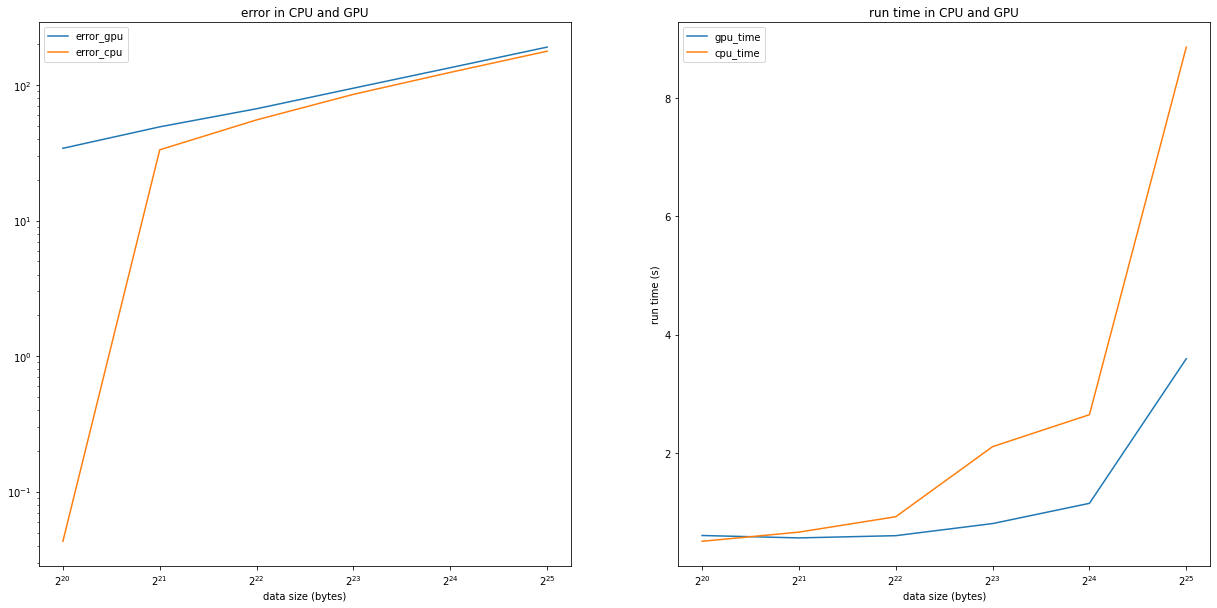

In [21]:
plt.figure(figsize=(21,10))

plt.subplot(121)
plt.plot(result[0,:], result[1,:], label="error_gpu")
plt.plot(result[0,:], result[2,:], label="error_cpu")
plt.loglog(basex=2)
plt.xlabel("data size (bytes)")
plt.title("error in CPU and GPU")
plt.legend()

plt.subplot(122)
plt.plot(result[0,:], result[3,:], label="gpu_time")
plt.plot(result[0,:], result[4,:], label="cpu_time")
plt.xscale("log", basex=2)
plt.xlabel("data size (bytes)")
plt.ylabel("run time (s)")
plt.title("run time in CPU and GPU")
plt.legend()

plt.show()

# More epoches

In [23]:
import pycuda.autoinit

In [24]:
def stop_watch(n):
    BD = 32 * 32
    GD_x = n

    A = np.float32(np.random.randn(BD*GD_x,BD))
    b = np.float32(np.random.randn(BD*GD_x))

    LSTSQ = LeastSquare(A, b, epoches=3, GD_x=GD_x)

    # in GPU
    error_gpu, gpu_time = LSTSQ.lstsq()
    
    # in CPU
    t1 = time()
    result_cpu = np.linalg.lstsq(A,b, rcond=None)[0]
    t2 = time()

    error_cpu = np.linalg.norm(np.dot(A, result_cpu) - b)

    cpu_time = t2 - t1
    
    return error_gpu, error_cpu, gpu_time, cpu_time

In [28]:
N = 6

result = np.zeros((5,N))

for i in range(N):
    result[0,i] = 2**i * (32 * 32) ** 2
    result[1:,i] = stop_watch(2**i)

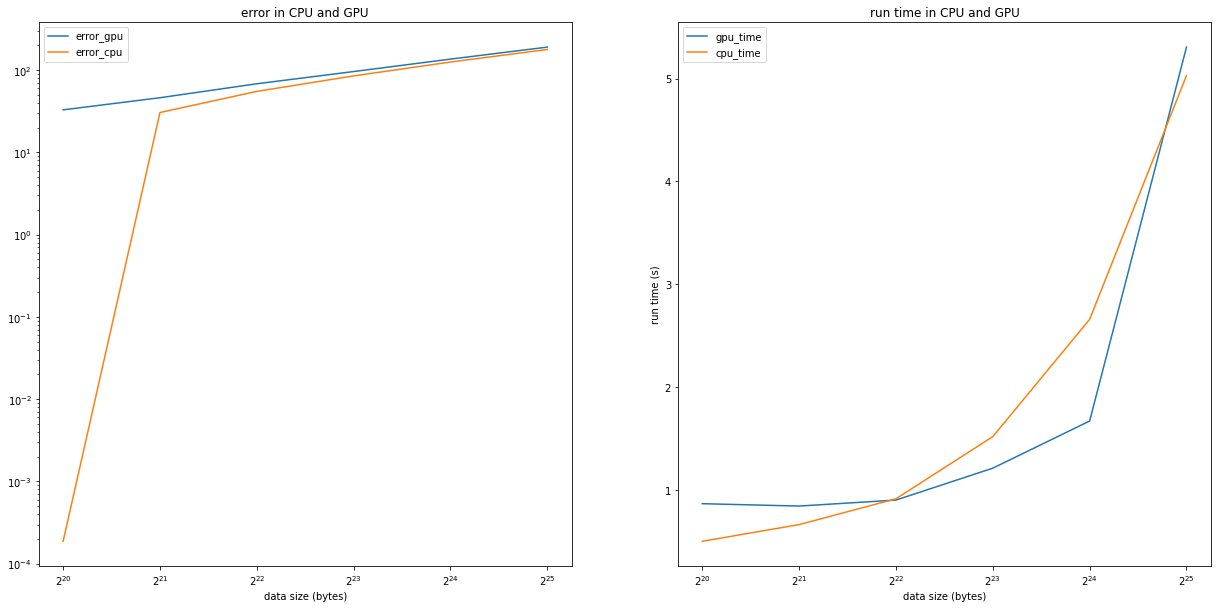

In [29]:
plt.figure(figsize=(21,10))

plt.subplot(121)
plt.plot(result[0,:], result[1,:], label="error_gpu")
plt.plot(result[0,:], result[2,:], label="error_cpu")
plt.loglog(basex=2)
plt.xlabel("data size (bytes)")
plt.title("error in CPU and GPU")
plt.legend()

plt.subplot(122)
plt.plot(result[0,:], result[3,:], label="gpu_time")
plt.plot(result[0,:], result[4,:], label="cpu_time")
plt.xscale("log", basex=2)
plt.xlabel("data size (bytes)")
plt.ylabel("run time (s)")
plt.title("run time in CPU and GPU")
plt.legend()

plt.show()

More epoches is 쓸모없음...